In [1]:
!pip install pymorphy2
from google.colab import drive
drive.mount('/content/drive')

!pip install phonetic-algorithmIPA
from phonetic_algorithmIPA import ipa_distances
ipa = ipa_distances.PhoneticAlgorithmIPA()

     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 7.1MB 7.0MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import re
import networkx as nx
import sklearn
import pickle
import pymorphy2


from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from collections import Counter
morph = pymorphy2.MorphAnalyzer()
load_model = pickle.load(open('model.sav', 'rb'))

In [4]:
verses = pd.read_csv('/content/drive/My Drive/verses.csv', sep = '\t')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (26,27,28,31,32,42,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
with open ('rules.csv', 'r', encoding = 'utf-8') as r:
    rules = r.read()
rules = rules.split('\n')
list_rules = []
for i in rules:
    list_rules.append(i.split(';'))

In [0]:
# ФУНКЦИЯ ПРИМЕНЯЕТ ПРАВИЛА ПЕРЕХОДОВ (ПРЕОБРАЗОВАНИЕ В ТРАНСКРИПЦИЮ) К БУКВЕ

def zamena(word, index_letter, rule):
    letter = word[index_letter]
    if rule[0] == word[index_letter]:
        if rule[2] == '':
            word = word.replace(word[index_letter], rule[1])
            return word

        if rule[2][1] == word[index_letter+1] or rule[2][0] == word[index_letter-1]:
            if rule[2][1] == word[index_letter+1]:
                word = word.replace(word[index_letter], rule[1], 1)
                return word

        if rule[2][0] == word[index_letter-1]:
            print(rule[2][0])
            word = word.replace(word[index_letter], rule[1], 1)
            return word

        else:
            return word
    else:
        return word


In [0]:
# РАЗБИЕНИЕ ПРАВИЛ ПО ОЧЕРЕДНОСТИ ПРИМЕНЕНИЯ К СЛОВУ

def rule_for_letter(letter, rules):
    firstPrior_rules_for_letter = []
    SecondPrior_rules_for_letter = []

    for rule in rules:
        if rule[0] == letter and rule[2] != '':
            firstPrior_rules_for_letter.append(rule)

        elif rule[0] == letter and rule[2] == '':
            SecondPrior_rules_for_letter.append(rule)
            
    return firstPrior_rules_for_letter + SecondPrior_rules_for_letter


In [0]:
# ФУНКЦИЯ ДЕЛАЕТ ТРАНСКРИПЦИЮ

def make_trans(word):
    word_base = word
    index_letter = 0
    for letter in word:
        prioritete_rule = rule_for_letter(letter, list_rules)
        for i in prioritete_rule:
            word = zamena(word, index_letter, i)
        if len(word) - len(word_base) >= 4:
            index_letter += int(1+ (len(word) - len(word_base))/2)
        else:
            index_letter += 1 + len(word) - len(word_base)

        word_base = word
    return word

In [0]:
# СОЕДИНЯЕТ ДИАКРИТИКИ И ДРУГИЕ СПЕЦИАЛЬНЫЕ ЗНАКИ С ЗВУКАМИ, К КОТОРЫМ ОНИ ОТНОСЯТСЯ. 
# ФУНКЦИЯ НА ВХОД ПОЛУЧАЕТ СЛОВО В ВИДЕ ТРАНСКРИПЦИИ, ДИАКРИТИЧЕСКИЙ ИЛИ ПРОСОДИЧЕСКИЙ
# СИМВОЛ И БУКВУ К КОТОРОЙ ОТНОСИТСЯ ЭТОТ СИМВОЛ



def find_diacr(word, letter, symbol):
    diacritic = { "ʲ" : 'pos', "ː" : 'pos', '̀' : 'pos',  ")" : 'betw'}
    word = list(word)
    if symbol == letter:
        if diacritic[symbol] == 'pos':
            pre = word[:word.index(letter) - 1]
            diacr = [word[word.index(letter) - 1] + word[word.index(letter)]]
            post = word[word.index(letter) + 1:]
            new_word = pre + diacr + post
            return new_word, letter


        elif diacritic[symbol] == 'pre':
            pre = word[:word.index(letter)]
            diacr = [word[word.index(letter)] + word[word.index(letter)+ 1 ]]
            post = word[word.index(letter) + 2:]
            new_word = pre + diacr + post
            letter = word[word.index(letter) + 2]
            return new_word, letter 
      
        elif diacritic[symbol] == 'betw':
            pre = word[:word.index(letter) - 1]
            diacr = [word[word.index(letter) - 1 ] + word[word.index(letter)] + word[word.index(letter)+ 1]]
            post = word[word.index(letter) + 2:]
            new_word = pre + diacr + post
            letter = word[word.index(letter) + 2]
            return new_word, letter 

    else:
        return word, letter
    

In [0]:
# РАЗДЕЛЯЕТ ВСЕ СЛОВА В СПИСКЕ НА СЕГМЕНТЫ (ИМЕЮТСЯ В ВИДУ ЗВУКОВЫЕ СЕГМЕНТЫ)

def make_segments_list(big_list_trans):
    segments = []
    for word in big_list_trans:
        try:
            for letter in word:
                for symbol in diacritic.keys():
                    word, letter = find_diacr(word, letter, symbol)
        except ValueError:
            pass
        segments.append(word)
    return segments


In [0]:
#  ФУНКЦИЯ НУЖНА ДЛЯ ОТСЕВА СЛОВ В КОТОРЫХ ВСТРЕЧАЮТСЯ НЕ КИРИЛЛИЧЕСКИЕ СИМВОЛЫ

def is_allowed(string):
    characherRegex = re.compile(r"[^а-яА-я\s0-9'̀.]")
    string = characherRegex.search(string)
    return not bool(string)

In [0]:
# ДОСТАЕТ СЛОВА В ЗОНЕ РИФМОВКИ. БЕРЕТ ПЕРВОЕ СЛОВО С КОНЦА СТРОКИ ЕСЛИ ОНО
# ДЛИННЕЕ ТРЕХ СИМВОЛОВ, ИНАЧЕ - ПОСЛЕДНИЕ ДВА СЛОВА

def find_last_words_l(stich):
    list_word_to_transc = []
    for i in stich:
        if i != '' or is_allowed(i) == True:
            last_word = i.rstrip(' ').split(' ')[-1]
            if len(last_word) >= 4:
                word_to_transc = last_word
                list_word_to_transc.append(word_to_transc)
            else:
                word_to_transc = i.split(' ')[-2:]
                word_to_transc = ''.join(word_to_transc)
                list_word_to_transc.append(word_to_transc)
        else:
            stich.remove(i)
    return list_word_to_transc

In [0]:
# ДЕЛАЕТ ТРАНСКРИПЦИЮ ДЛЯ СПИСКА СЛОВ

def make_trans_for_list(list_word_to_transc):
    list_transc_push = []
    for i in list_word_to_transc:
        if ' ' in i:
            two_words_in_one = i.replace(' ' , '')
            list_transc_push.append(make_trans(two_words_in_one + '#'))
        else:
            list_transc_push.append(make_trans(i+'#'))
    return list_transc_push


In [0]:
# ВЫДЕЛЯЕТ ПОСЛЕДНИЕ ЧЕТЫРЕ ЭЛЕМЕНТА В СЛОВЕ

def segments_four_last_func(segments):
    segments_four_last = ''
    count = 0
    for i in segments:
        str_word = ''
        str_word = ''.join(i[-5:-1:])
        if count % 2 == 0:
            segments_four_last += ''.join(str_word + ';')
            count += 1
        else:
            segments_four_last += ''.join(str_word + '\n')
            count += 1
    return segments_four_last

In [0]:
# СЧИТАЕТ РАССТОЯНИЕ ПО ЛЕВЕНШТЕЙНУ МЕЖДУ ДВУМЯ СТРОКАМИ. СОЗДАЕТ ФАЙЛ, В КОТОРЫХ 
# ЗАПИСЫВАЕТ ПРОМЕЖУТОЧНЫЕ РЕЗУЛЬТАТЫ. 

def find_distance(str_word_first, str_word_second):
    with open('trans_four.csv', 'w', encoding = 'utf-8') as f:
        f.write(str_word_first + ';' + str_word_second)
    c = ipa.phonetic_transformer('trans_four.csv', 'rules.csv')
    return c



In [0]:
# ПРИПИСЫВАЕТ ФОНОЛОГИЧЕСКИЕ ПРИЗНАКИ ЗВУКОВЫМ СЕГМЕНТАМ, ВЫДАЕТ СПИСОК СО СПИСКАМИ

with open ('priznakiV.txt', 'r') as f:
    priznaki = f.readlines()

list_priznaki = []
for i in priznaki:
    list_priznaki.append(i.split(';'))

def create_matrix_priz(list_priznaki, word):
    list_priz_for_word = []
    for letter in word[-4:-1:]:
        for i in list_priznaki:
            if letter == i[0]:
                list_priz_for_word.append(i[2:18])
    return list_priz_for_word

In [0]:
# ДЕЛИТ СЛОВО НА СЕГМЕНТЫ (НЕ ПУТАТЬ С make_segments_list)

def make_segments_for_word(word):
    for letter in word:
        for symbol in diacritic.keys():
            word, letter = find_diacr(word, letter, symbol)
        # print(word)
    return word


In [0]:
# ФУНКЦИЯ ВОЗВРАЩАЕТ ВЕКТОР В КОТОРОМ ЕДИНИЦАМИ УКАЗАНЫ ОБЩИЕ ЭЛЕМЕНТЫ, А НУЛЯМИ РАЗЛИЧНЫЕ
# (СВОДНЫЙ ВЕКТОР)

def matr_egal(matr1, matr2):
    list_egalite = []
    for i in range(len(matr1)):
        for j in range(len(matr1[i])):
            if matr1[i][j] == matr2[i][j]:
                list_egalite.append(1)
            else:
                list_egalite.append(0)
    return list_egalite


In [0]:
# ДЛЯ КАЖДОЙ СТРОКИ (startword) ЗАПИСЫВАЕТ В befor ЧЕТЫРЕ СТРОКИ ПРЕДШЕСТВУЮЩИЕ ЕЙ
# after - СЛЕДУЮЩИЕ ЗА startword

def find_eight_string(list_words, startword, count_str):
    if count_str == 0 or count_str == 1 or count_str == 2 or count_str == 3:
        befor = list_words[: count_str]
    else:
        befor = list_words[count_str -4  : count_str]
    after = list_words[count_str + 1 :count_str + 5]
    return befor, after

In [0]:
# ПРОГА СОЗДАЕТ СВОДНЫЙ ВЕКТОР, КОТОРЫЙ ПОДАЕТСЯ НА ВХОД МОДЕЛИ. ФУНКЦИЯ ВОЗВРАЩАЕТ
# ПАРУ СЛОВ, ЕСЛИ ОНИ РИФМУЮТСЯ

def pred_rythm(word1, word2, count_str, count_str2):
    tr = make_trans(word1 + '#')
    tr2 = make_trans(word2 + '#')

    tr_seg = make_segments_for_word(tr)
    tr_seg2 = make_segments_for_word(tr2)

    nonr = matr_egal(create_matrix_priz(list_priznaki, make_segments_for_word(tr)), create_matrix_priz(list_priznaki, make_segments_for_word(tr2)))
    nonr = np.array(nonr).reshape(1, -1)
    if load_model.predict(nonr) == ['1']:
        return word1 + ' ' + str(count_str), word2 + ' ' + str(count_str2)

In [0]:
# СОЗДАЕТ СПИСОК КОРТЕЖЕЙ, В КОТОРОМ ДЛЯ КАЖДОГО СЛОВА ПОПАВШЕГО В ЗОНУ РИФМОВКИ
# ПЕРЕЧИСЛЕНЫ РИФМОВЫЕ ПАРЫ СЛОВ

def make_corteg_of_nodes_of_startword(startword, befor, after, list_corteg_of_nodes, count_str):
    if after != []:
        count_str2 = count_str + 1
        for i in after:
            cort = pred_rythm(startword, i, count_str, count_str2)
            if cort != None:
                list_corteg_of_nodes.append(cort)
            count_str2 += 1

    return list_corteg_of_nodes

In [0]:
# ВЫБИРАЕТ ИЗ НЕСКОЛЬКИХ ВАРИАНТОВ РИФМОВЫХ ПАР У СЛОВА ОДИН.

def find_min(node, G):
    min_dist = 3
    cort_min = ()
    
    list_node2 = list(G.adj[node])
    word1 = node.split()[0]
    for node2 in list_node2:
        word2 = node2.split()[0]
        two_seg_of_word = make_segments_list(make_trans_for_list([word1, word2]))
        w1 = ''.join(two_seg_of_word[0][-4:-1:])
        w2 = ''.join(two_seg_of_word[1][-4:-1:])
        distance = find_distance(w1, w2)[0]
        if min_dist == 3:
            min_dist = distance
            cort_min = (node, node2)
        elif min_dist > distance:
            min_dist = distance
            cort_min = (node, node2)
    return cort_min

In [0]:
# ДЛЯ СТИХОТВОРЕНИЯ СОЗДАЕТ ГРАФ В КОТОРОМ УЗЛЫ - СЛОВА. РЕБРА СОЕДИНЯЮТ ДВА УЗЛА, ЕСЛИ ОНИ РИФМУЮТСЯ.

def create_edges_ru(stix):
    G = nx.Graph()
    New_G = nx.Graph()
    list_word_to_transc = find_last_words_l(stix)
    list_corteg_of_nodes = []
    count_str = 0
    for i in list_word_to_transc:
        if type(i) == list:
            i = ' '.join(i)
        else:
            pass
        befor_startword, after_startword = find_eight_string(find_last_words_l(stix), i, count_str)
        list_corteg_of_nodes = make_corteg_of_nodes_of_startword(i, befor_startword, after_startword, list_corteg_of_nodes, count_str)
        count_str += 1
    G.add_edges_from(list_corteg_of_nodes)
    for node in G.nodes():
        if G.degree[node] > 1:
            cort_min = find_min(node, G)
            New_G.add_edge(cort_min[0], cort_min[1])
        else:
            New_G.add_edge(node, list(G[node])[0])
    return New_G

In [0]:
# ОПРЕДЕЛЯЕТ ВИДЫ РИФМЫ

# ОПРЕДЕЛЕНИЕ ТОЧНОЙ РИФМЫ
def detect_tochn(word1, word2):
    Vowels = re.findall(r'[а,и,ю,я,е,э,о,ы,у,̀ ]', word1)
    l_word = []
    for w in [word1, word2]:
        w_count = []
        for i in w:
            w_count.append(i)
        c = Counter(w_count)
        if c['̀'] == 0:
            return 'неопределена'
        elif c['̀'] > 1:
            for x in range(c['̀']-1):
                del w_count[w_count.index('̀')]
        l_word.append(w_count)
    if l_word[0][l_word[0].index('̀'):] == l_word[1][l_word[1].index('̀'):]:
        return 'точная'
    else:
        return 'неточная'

# ОПРЕДЕЛЕНИЕ РИФМЫ ПО МЕСТУ УДАРЕНИЯ
def detect_accent(word1, word2):
    Vowels = re.findall(r'[а,и,ю,я,е,э,о,ы,у,̀ ]', word1)
    if '̀' not in Vowels:
        return 'неопределена'
    elif Vowels[-1] == '̀':
        return 'мужская'
    elif Vowels[-2] == '̀':
        return 'женская'
    elif Vowels[-3] == '̀':
        return 'дактилическая'
    elif Vowels[-4] == '̀':
        return 'гипердактилическая'

# ОПРЕДЕЛЕНИЕ ОДНОРОДНОЙ/РАЗНОРОДНОЙ РИФМЫ
def detect_odnorodn(word1, word2):
    mor_word1 = morph.parse(word1)[0]
    mor_word2 = morph.parse(word2)[0]
    if mor_word1.tag.POS == mor_word2.tag.POS:
        return 'однородная'
    elif mor_word1.tag.POS != mor_word2.tag.POS and mor_word2.tag.POS not in ['PRCL', 'INTJ', 'CONJ', 'PREP'] and mor_word2.tag.POS not in ['PRCL', 'INTJ', 'CONJ', 'PREP']:
        return 'разнородная'
    else:
        return 'составная'

# ОПРЕДЕЛЕНИЕ БЕДНОЙ/БОГАТОЙ РИФМЫ
def detect_bednaya(word1, word2):
    Vowels = re.findall(r'[а,и,ю,я,е,э,о,ы,у,̀ ]', word1)
    l_word = []
    for w in [word1, word2]:
        w_count = []
        for i in w:
            w_count.append(i)
        c = Counter(w_count)
        if c['̀'] == 0:
            return 'неопределена'
        elif c['̀'] > 1:
            for x in range(c['̀']-1):
                del w_count[w_count.index('̀')]
        l_word.append(w_count)
    last_V1 = l_word[0][l_word[0].index('̀') - 1]
    last_V2 = l_word[1][l_word[1].index('̀') - 1]
    last_C1 = l_word[0][l_word[0].index('̀') - 2]
    last_C2 = l_word[1][l_word[1].index('̀') - 2]
    if last_V1 == last_V2 and last_C1 == last_C2:
        return 'богатая'
    elif last_V1 == last_V2 and last_C1 != last_C2:
        return 'бедная'
    else:
        return 'неопределена'


In [0]:
# ОПРЕДЕЛЕНИЕ РИФМЫ, ЗАПИСЬ В ДАТАФРЕЙМ С

def detec_ry_func(New_G, header, name_col, df_detec_ry, stix, index_header):
    df_detec_ry2 = pd.DataFrame(columns = name_col)
    count_num_col = 0
    for edge in New_G.edges():
        word1 = edge[0].split()[0]
        word2 = edge[1].split()[0]
        ry_accent = detect_accent(word1, word2)
        ry_tocnhn = detect_tochn(word1, word2)
        ry_odnor = detect_odnorodn(word1, word2)
        ry_bedn = detect_bednaya(word1, word2)
        author = verses.loc[index_header, 'Author']
        year = verses.loc[index_header, 'Year']
        stroka = stix[int(edge[0].split()[1])]

        df_detec_ry2.loc[count_num_col] = year, author, header, stroka, word1, word2, ry_accent, ry_tocnhn, ry_odnor, ry_bedn
        count_num_col += 1

    df_detec_ry = df_detec_ry.append(df_detec_ry2)
    return df_detec_ry


In [0]:
# СЧИТЫВАЕТ ИЗ ДАТАФРЕЙМА СО ВСЕМИ СТИХАМИ ПО ОДНОМУ СТИХОТВОРЕНИЮ
def make_stix(verses, header, group_header):
    stix = []
    df = group_header.get_group(header)
    st = df['LineText'].values.tolist()
    for i in st:
        i = i.lower()
        i = i.replace(' -- ', ' ').replace('-', ' ')
        i = re.sub(r"[,!?.;:\(\)\…\'\"\»\«\—\-0-9]", '', i)
        stix.append(i.rstrip(' '))
    return stix

In [58]:
group_header = verses.groupby('Header')
list_Header = list(set(verses['Header'].to_list()))
col = ['год', 'автор', 'заголовок', 'строка', 'слово1', 'слово2', 'рифма_ударение', 'рифма_точная', 'рифма_однородность', 'рифма_богатая']
df_detec_ry = pd.DataFrame(columns = col)
for header in list_Header[:12]:
    try:
        index_header = verses.loc[verses['Header'] == header].index[0]
        print(header)
        stix = make_stix(verses, header, group_header)
        New_G = create_edges_ru(stix)
        df_detec_ry = detec_ry_func(New_G, header, col, df_detec_ry, stix, index_header)
    except:
        pass

# ДАТАФРЕЙМ С
df_detec_ry

Раб и Свободный : «С Греком Галл несхож -- и сходен...»
Демон : «В те дни, когда мне были новы...»
Свиданье : «Был купол храма в небе светел...»
Земля : «Ты помнишь ли случай, родная?...»
Тезей Ариадне : ««Ты спишь, от долгих ласк усталая...»
Черемуха : «Черемухой душистой с тобой опьянены...»
«Лампа моя равнодушно мне светит...»
Ave, sтеlla maris : «Дымно тает берег плоский...»
«Я оплакал себя, схоронил...»
Слава : «Какой таинственною силой...»
Послание К. Р. : «Ваше высочество, ваш благосклонный...»
«Повеселясь на буйном пире...»


,год,автор,заголовок,строка,слово1,слово2,рифма_ударение,рифма_точная,рифма_однородность,рифма_богатая
0,1823,А. С. Пушкин,"Демон : «В те дни, когда мне были новы...»",в те днѝ когда̀ мне бы̀ли но̀вы,но̀вы,дубро̀вы,женская,точная,однородная,бедная
1,1823,А. С. Пушкин,"Демон : «В те дни, когда мне были новы...»",когда̀ возвы̀шенны̀е чу̀вства,чу̀вства,иску̀сства,женская,неточная,однородная,бедная
2,1823,А. С. Пушкин,"Демон : «В те дни, когда мне были новы...»",когда̀ возвы̀шенны̀е чу̀вства,чу̀вства,со̀ловья̀,женская,неточная,разнородная,неопределена
3,1823,А. С. Пушкин,"Демон : «В те дни, когда мне были новы...»",все впѐчатлѐнья бы̀тия̀,бы̀тия̀,со̀ловья̀,мужская,точная,однородная,бедная
4,1823,А. С. Пушкин,"Демон : «В те дни, когда мне были новы...»",свобо̀да сла̀ва ѝ любо̀вь,любо̀вь,кро̀вь,мужская,точная,однородная,бедная
...,...,...,...,...,...,...,...,...,...,...
1,1912,А. А. Блок,«Повеселясь на буйном пире...»,верну̀лся по̀здно я̀ домо̀й,домо̀й,мо̀й,мужская,точная,однородная,богатая
2,1912,А. А. Блок,«Повеселясь на буйном пире...»,слилѝсь все лѝца всѐ обѝды,обѝды,па̀нихѝды,женская,точная,однородная,бедная
3,1912,А. А. Блок,«Повеселясь на буйном пире...»,в одно̀ лицо̀ в одно̀ пятно̀,пятно̀,окно̀,мужская,точная,однородная,богатая
4,1912,А. А. Блок,«Повеселясь на буйном пире...»,лишь со̀блазнѝтель мо̀й не спѝт,спѝт,скѝт,мужская,точная,однородная,бедная


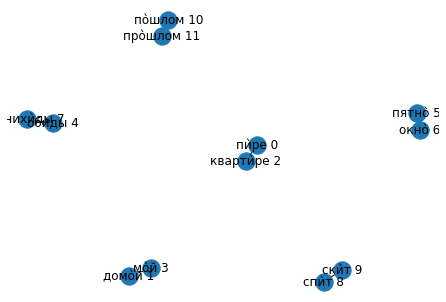

In [61]:
# ВИЗУАЛИЗАЦИЯ ГРАФА НА ПРИМЕРЕ ПОСЛЕДНЕГО СТИХОТВОРЕНИЯ ИЗ ДАТАФРЕЙМА

pos = nx.spring_layout(New_G)
nx.draw(New_G, pos, with_labels=True)